In [1]:
from biomime_generator import *

In [2]:
from emg_processor import *

In [4]:
# Import required libraries
import numpy as np
import torch

# Parameters for the pipeline
config_path = './config/config.yaml'
model_checkpoint = './ckp/model_linear.pth'
device = 'cpu' #cuda:0' if torch.cuda.is_available() else 'cpu'
n_mus = 100  # Number of motor units
duration = 1.0  # Duration in seconds
fs = 2000  # Sampling frequency in Hz
Tmean = 0.1  # Mean inter-spike interval in seconds
Tstd = 0.03  # Standard deviation of inter-spike interval
ext_factor = 10 # Extension factor for EMG
explained_var = 1 - 1e-14  # Explained variance for covariance truncation

# Step 1: Initialize the MUAP generator
biomime_gen = BiomimeMuapGenerator(config_path=config_path, model_checkpoint=model_checkpoint, device=device)
# Step 2: Generate conditions for MUAPs (e.g., power law)
conds = torch.rand(n_mus, 6).to(device)
conds = BiomimeMuapGenerator.generate_power_law_conditions(conds)

# Step 3: Generate MUAPs
muaps = biomime_gen.generate_muaps(conds)


In [4]:



# Step 4: Generate spike trains
spts, discharge_times = EMGProcessor.generate_spike_trains(n_mus, duration, fs, Tmean, Tstd)

# Step 5: Generate raw EMG signals
emg = EMGProcessor.generate_emg(spts, muaps)

# Step 6: Preprocess the EMG (extend and whiten)
extended_emg = EMGProcessor.extend_emg(emg, ext_factor)
#TODO here, do we need to take the centered EMG For the covariance(probably yes)
ext_emg_centered = extended_emg - np.mean(extended_emg, axis=1, keepdims=True)
whitened_emg, whitening_mat, dewhitening_mat = EMGProcessor.whiten_emg(ext_emg_centered, explained_var)
cov_matrix = EMGProcessor.get_inv_cov(extended_emg, explained_var=explained_var)


# Step 7: Generate separation vectors
#muaps_tensor = torch.tensor(muaps, dtype=torch.float32, device=device)
separation_vectors = EMGProcessor.get_separation_vectors(muaps, R=ext_factor)

# Output some results
print("Pipeline Complete!")
print(f"Generated MUAPs shape: {muaps.shape}")
print(f"Generated EMG shape: {emg.shape}")
print(f"Extended EMG shape: {extended_emg.shape}")
print(f"Whitened EMG shape: {whitened_emg.shape}")
print(f"Separation vectors shape: {separation_vectors.shape}")


Extending EMG: 100%|██████████| 10/10 [00:00<00:00, 670.76it/s]


Pipeline Complete!
Generated MUAPs shape: (100, 320, 96)
Generated EMG shape: (320, 2000)
Extended EMG shape: (3200, 2009)
Whitened EMG shape: (3200, 2009)
Separation vectors shape: (3200, 100)


In [ ]:
import numpy as np

# Save all arrays in a single .npz file
np.savez_compressed("emg_data.npz",
                     spike_trains=spts,
                     muaps=muaps,
                     emg=emg,
                     covariance_matrix=cov_matrix,
                     extended_emg=extended_emg,
                     base_conditions=conds,
                     zi=biomime_gen.zi)

# # Load the saved data
# loaded_data = np.load("emg_data_mu100_ext10.npz")

# # Access arrays
# spike_trails_loaded = loaded_data["spike_trails"]
# muaps_loaded = loaded_data["muaps"]

# print(spike_trails_loaded.shape)  # Ensure data integrity


[221 228 310  74 249 258 164 187  96 189 206  15  55 192 273 120]


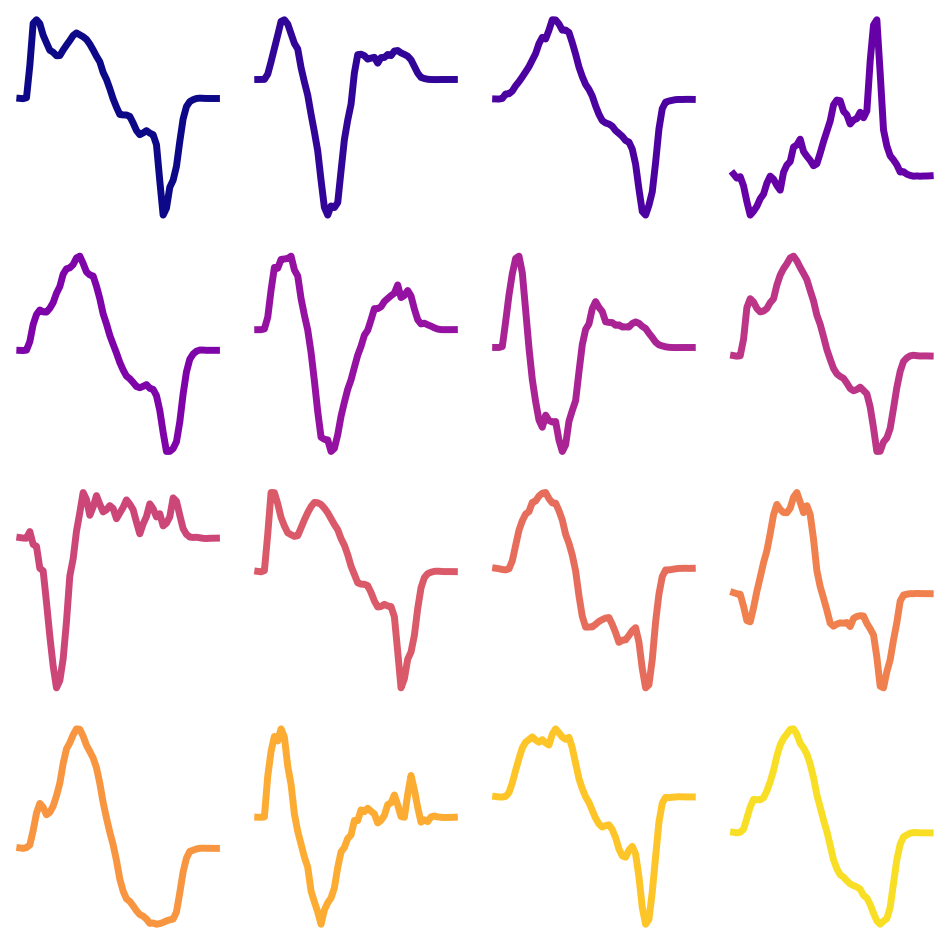

In [35]:
random_indices_320 = np.random.choice(320, 16, replace=False)
print(random_indices_320)
sampled_muaps = muaps[0, random_indices_320, :60]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Reduced spacing

for i, ax in enumerate(axes.flatten()):
    ax.plot(sampled_muaps[i], linewidth=5, color=plt.cm.plasma(i / 16))  # Increased line width and added color gradient
    ax.axis('off')

plt.show()

sampled_muaps.shapea

In [28]:
sampled_muaps.shape

(16, 96)

In [19]:
from matplotlib import pyplot as plt

whitened_separation_vectors = (whitening_mat @ separation_vectors)# apply transpose of whitening mtrix to separation vectors, such that we still get spikes from whitened obvs.
S_est = (whitened_separation_vectors.T @  whitened_emg)


#S_est = separation_vectors.T @ cov_matrix @ extended_emg 



In [20]:
import numpy as np

# Save all arrays in a single .npz file
np.savez_compressed("emg_data.npz",
                     spike_trains=spts,
                     muaps=muaps,
                     emg=emg,
                     covariance_matrix=cov_matrix,
                     extended_emg=extended_emg,
                     base_conditions=conds,
                     zi=biomime_gen.zi)

# # Load the saved data
# loaded_data = np.load("emg_data_mu100_ext10.npz")

# # Access arrays
# spike_trails_loaded = loaded_data["spike_trails"]
# muaps_loaded = loaded_data["muaps"]

# print(spike_trails_loaded.shape)  # Ensure data integrity


In [21]:
from metrics import *
avg = 0.0
n_components = 100

for i in range(n_components):
    
    sil = calculate_kmeans_and_silhouette(S_est[i][:7000], init_method='maxmin')['silhouette_score']
    avg += sil
    print(sil)

print(avg/n_components)


0.5202643372306891
0.5271925585179323
0.5208659336990888
0.5298141818298757
0.5311444552508706
0.531177034322877
0.518765220423093
0.5252366135420042
0.5213350865004687
0.5264617663487504
0.5310344313572674
0.5286715094934706
0.5235151899822998
0.5236085619800638
0.5194455955054281
0.5379969318507336
0.5206513832433511
0.520800362655737
0.5155735275718434
0.5288406837469388
0.5201906527924913
0.5289542403598335
0.5304837977454212
0.514320610259224
0.5325512816632124
0.5233443431035169
0.5178970025152085
0.5213983778101575
0.5212114300171857
0.5313621730375087
0.5198945763624098
0.5231318797179887
0.5256859929854132
0.521584779254471
0.523210079969295
0.5338505243438604
0.5275411291851045
0.5277628207205459
0.5345543034651613
0.5275812772757565
0.5252341262034647
0.5219758417979697
0.5335415387475598
0.5364273369814138
0.8984509871760497
0.5288396290598215
0.5257040478198126
0.53443635795684
0.5204035737567103
0.5384002147161431
0.5278658273106426
0.5342229806228729
0.5184334953464073
0

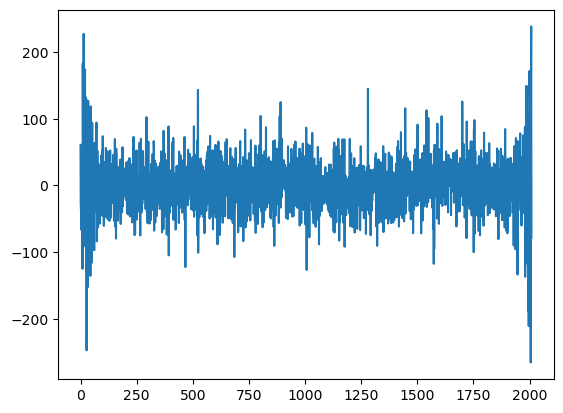

In [23]:
plt.plot(S_est[8])

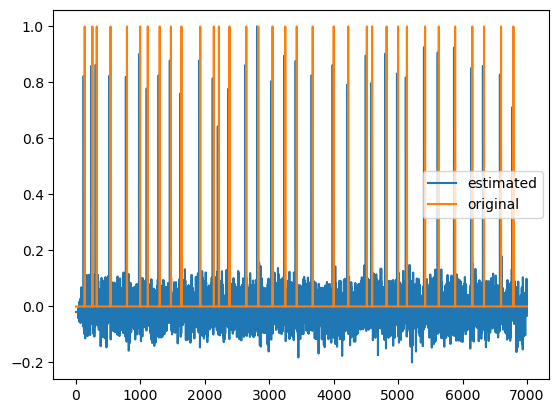

In [10]:
from matplotlib import pyplot as plt
i = 0

whitened_separation_vectors = (whitening_mat @ separation_vectors)# apply transpose of whitening mtrix to separation vectors, such that we still get spikes from whitened obvs.
mu1 = (whitened_separation_vectors.T[i, :] @  whitened_emg).ravel()
plt.figure()
plt.plot(S_est[i, 0:7000] / S_est[i].max())
plt.plot(spts[i,0:7000]/spts.max())
plt.legend(['estimated', 'original'])
# plt.savefig('mu')
plt.show()

In [11]:
# Example usage:
np.random.seed(42)  # For reproducibility
S_true = spts


threshold_est = 0.3
threshold_true = 0.9
S_est = normalize_sources(S_est)



matches, recall_matrix,thresholds_est, thresholds_true = \
    match_estimates_to_true(S_est, S_true, threshold_est=threshold_est, threshold_true=0.9)

precision_list, recall_list, mean_precision, mean_recall = evaluate_matches(
    S_est, 
    S_true, 
    matches, 
    thresholds_est, 
    thresholds_true
)


In [12]:
matches

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 34, 36, 37, 38, 39, 40,  6, 42, 43, 35, 45, 46, 47, 48, 49,  6,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 55, 65, 20, 67,
       68, 69, 70, 71, 16, 43, 74, 75,  5,  5, 78, 79, 80, 81, 27, 83,  0,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 71, 20, 96, 97, 98, 99])

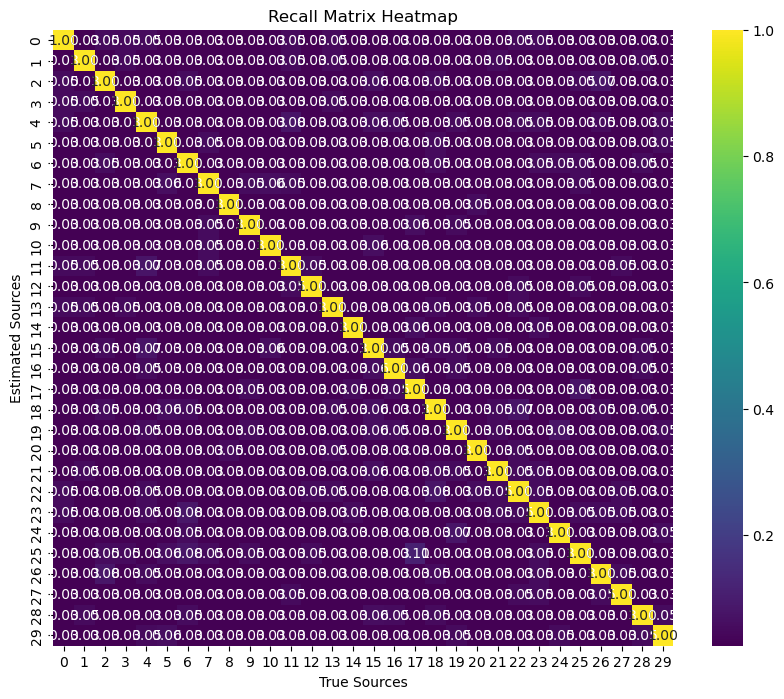

In [13]:
import seaborn as sns

recall_matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(recall_matrix[0:30, 0:30], annot=True, cmap='viridis', fmt=".2f")
plt.title('Recall Matrix Heatmap')
plt.xlabel('True Sources')
plt.ylabel('Estimated Sources')
plt.show()

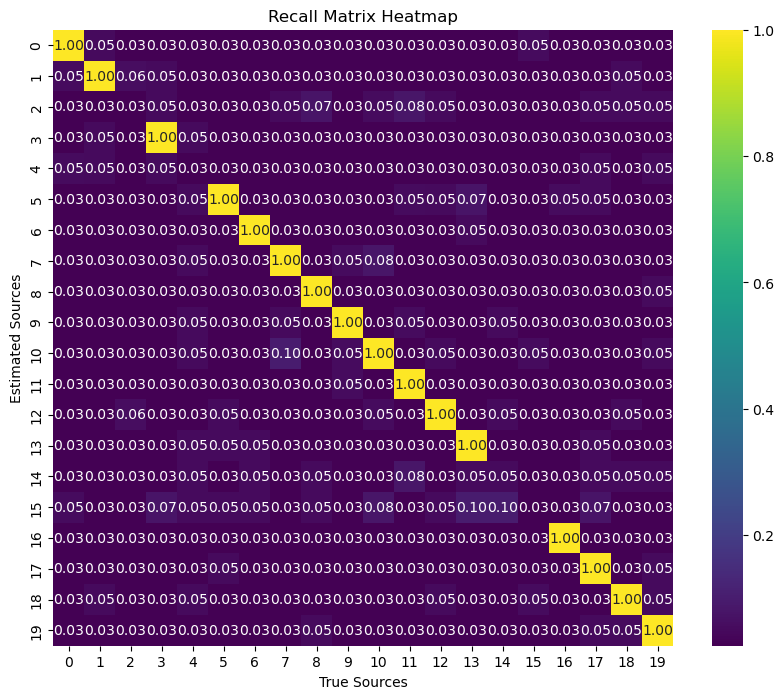

In [14]:
import seaborn as sns

recall_matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(recall_matrix[80:, 80:], annot=True, cmap='viridis', fmt=".2f")
plt.title('Recall Matrix Heatmap')
plt.xlabel('True Sources')
plt.ylabel('Estimated Sources')
plt.show()

In [15]:
S_true

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
from decomposition import fastICA_prewhitened
# --------------------------------------------------------------------
# Example usage
# --------------------------------------------------------------------
# 3) Run FastICA to recover sources
n_components = 50
S_est, W_est = fastICA_prewhitened(extended_emg, n_components=n_components, max_iter=1000, tol=1e-10)

# 4) (Optional) Compare recovered signals to the original
print("Unmixing matrix shape:", W_est.shape)

# S_est are the recovered independent components (in arbitrary order/sign).
# You can visually inspect them or measure correlation with the true signals


100%|██████████| 1000/1000 [01:07<00:00, 14.84it/s]

Unmixing matrix shape: (50, 3200)


In [17]:
avg = 0.0
for i in range(n_components):
    sil = calculate_kmeans_and_silhouette(S_est[i][0:7000])['silhouette_score']
    avg += sil
    print(sil)

print(avg/n_components)

0.8327029467800785
0.8616784603285607
0.9028718186203131
0.8139558671573356
0.8395651441499012
0.887116943233362
0.943552581865733
0.8336335286929006
0.9029457558789598
0.8412644205547574
0.8736898507076714
0.8791697666031146
0.8987238823883538
0.8449280493055473
0.8040269995253032
0.503192378959914
0.7800265162344696
0.7875461034778283
0.9273135058277001
0.5323073286631762
0.8564658855259788
0.8914053273245003
0.9037759244800742
0.898125409335189
0.6958421834022741
0.9123451476792683
0.6837707542744119


KeyboardInterrupt: 

In [18]:
print(avg/n_components)

0.8661684450101497


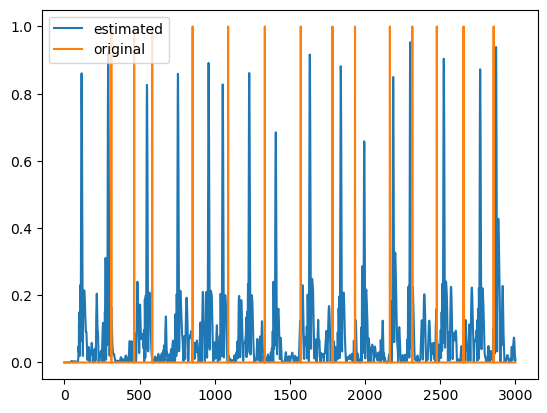

In [19]:
S_est = np.abs(S_est)
i = 12
plt.figure()
plt.plot(S_est[i, :3000] / S_est[i].max())
plt.plot(spts[i,:3000]/spts.max())
plt.legend(['estimated', 'original'])
# plt.savefig('mu')
plt.show()